# Final Project EDA

## 주제: 항생제 감수성 예측


- Preprocess, EDA 수행


```
Introduction

응급 환자에게 있어서, 항생제 감수성 여부는 중요한 요소이다.
응급한 상황에서 항생제 1차, 2차, 3차를 투여하기에는 위험 부담이 클 뿐만아니라, 지역 항생제 감수성이 만연하게 될 것이다.
3차의 부작용이 세다.
환자의 감수성에 맞춰 1차,2차 항생제를 투여하고,  3차 항생제를 투여하지않는다면 많음 부담을 줄일 수 있을 것이다.

그래서, 환자의 감수성을 예측하는 것이 중요하다.

주요 가설은 다른 병원에 오래 있거나 고령, 침상 환자들은 지속적으로 항생제를 투여해서, 감수성이 있을것이란 것이다.

항생제중 ciprofloxacin(CIP) 감수성 여부가 target이다.
CIP를 치료로 이용하는 병균 감염에는 뼈 및 관절염, 복강내 전염, 특정한 종류의 장염, 호흡기 감염, 피부 감염, 장티푸스, 요로감염증 등이 포함된다. 

그 외의 수치형 변수들을 포함해 분석하고,  CIP classification을 위한 KEY FEATURE를 선정하는 것을 목표로 한다.



```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import sys

import scipy.stats as stats # qqplot에 사용

In [2]:
#시각화 패키지들
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

plt.style.use("ggplot")

## 변수 설명




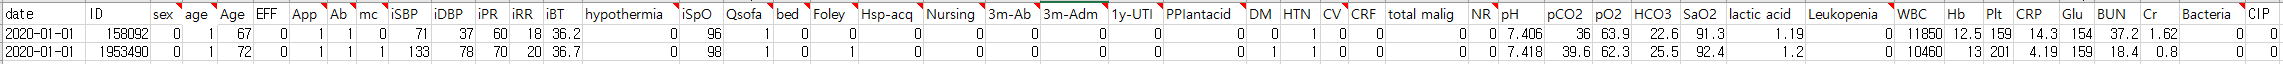

In [4]:
X = pd.read_excel("../data/CIP_data.xlsx")
print(X.shape)
X.head()

(550, 47)


,date,ID,sex,age,Age,EFF,App,Ab,mc,iSBP,...,Leukopenia,WBC,Hb,Plt,CRP,Glu,BUN,Cr,Bacteria,CIP
0,2020-01-01,158092,0,1,67,0,1.0,1.0,0,71,...,0,11850,12.5,159,14.30,154,37.2,1.62,0,0
1,2020-01-01,1953490,0,1,72,0,1.0,1.0,1,133,...,0,10460,13.0,201,4.19,159,18.4,0.80,0,0
2,2020-01-01,1953526,0,1,74,0,1.0,1.0,0,172,...,0,8430,12.7,183,9.24,269,13.0,0.70,0,0
3,2020-01-01,1260373,1,1,78,0,1.0,2.0,0,166,...,0,5740,11.9,152,4.59,138,29.5,1.73,0,1
4,2020-01-02,1842207,0,0,48,0,1.0,1.0,0,122,...,0,10530,12.3,207,0.18,109,11.5,0.97,0,0


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 47 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         550 non-null    object 
 1   ID           550 non-null    int64  
 2   sex          550 non-null    int64  
 3   age          550 non-null    int64  
 4   Age          550 non-null    int64  
 5   EFF          550 non-null    int64  
 6   App          361 non-null    float64
 7   Ab           546 non-null    float64
 8   mc           550 non-null    int64  
 9   iSBP         550 non-null    int64  
 10  iDBP         550 non-null    int64  
 11  iPR          550 non-null    int64  
 12  iRR          550 non-null    int64  
 13  iBT          550 non-null    float64
 14  hypothermia  550 non-null    int64  
 15  iSpO         530 non-null    float64
 16  Qsofa        550 non-null    int64  
 17  bed          550 non-null    int64  
 18  Foley        550 non-null    int64  
 19  Hsp-acq 

```
(date형) date : 검사 날짜. (제거)
(수치) id: (제거)
(범주형) sex : 성별 [0:여,1:남 ]
(범주형) age : 65세 [전:0 후:1] (분포를 보고 다시 결정)
(수치형) Age : 나이
(범주형) EFF : Effectiveness. 감수성 여부를 떠나서 효과가 있었던 사람. (삭제해도되는 것.)
(범주형) App : 응급실에서 적절한 항생제를 사용했는지 여부. (제거 예정. 차후 결과 비교에 사용) (Ab 이용)
(범주형) Ab :  응급실에서 어떤 항생제를 투여했는지 여부, (0:CIP ,1:CTX ,2:PT ,3:Maxipime , 4 :no) (제거 예정)
(범주형) mc : mental change. 환자 의식이 변화된 정. (없으면0 생기면 1) (제거 예정)
(수치형) iSBP : 침습적 혈압 측정. invasive blood pressure 
(수치형) iDBP : 침습적 이완기 혈압 측정. invasive Diastolic  blood pressure
(수치형) iRR : 
(수치형) iBT : 
(범주형) hypothermia : 36도 미만 저체온 여부 (분포 보고 다시 결정.)
(수치형) iSpO : ??(저널 참고)
(범주형,label encoding) Qsofa : ?? (저널)
(범주형) **bed : 침상환자 여부
(범주형) Fooley : 도뇨관? (저널)
(범주형) **Hsp-acq hospital acquired : 최근 수술 및 입원 여부 ??? 3개 label인지 (1. 2일 이상 입원후 전원 2. 30일내 수술력 3. 퇴원한지 3일내)
(범주형) Nursing : 요양원,가정 간호 여부
(범주형) 3m-Ab : 3달 이내 항생제 복용여부 
(범주형) 3m-Adm : 최근 3달내 입원 여부
(범주형) **1y-UTI : 1년내 요로감염이력
(범주형) PPlantacid : 위식도 역류질환 제산제 사용여부
(범주형) CV : 혈압 제외 심장질환 여부 (CAOD, HCMP, CHF)
(범주형) CRF  : 만성신부전 여부?? Chronic Renal Failure
(범주형) total malig :  ??(저널)
(범주형) NR : neurodegenerative disease 여부 :CVA, Dementia,CP 포함.
(범주형) Leukopenia : 백혈구 감소증 여부. WBC<4000 (domain내용으로 사용예정.)
(수치형) Hb	헤모글로빈
(수치형) Plt	
(수치형) CRP	
(수치형) Glu	글루테인
(수치형) BUN	
(수치형) Cr
(범주형) Bacteria : 박테리아 감염 여부. 어떤 박테리아냐에 따라 (ground-truth와 같이나와 사용x)
(범주형 TARGET) CIP : CIP 내성 여부. (소변검사 실시. ground truth)

tree 계열은 한 노드당 하나의 feature를 보기에, 자료형에 관계없이 분석가능하다.

```

In [7]:
X.describe()

,ID,sex,age,Age,EFF,App,Ab,mc,iSBP,iDBP,...,Leukopenia,WBC,Hb,Plt,CRP,Glu,BUN,Cr,Bacteria,CIP
count,5.500000e+02,550.000000,550.000000,550.000000,550.000000,361.000000,546.000000,550.000000,550.000000,550.000000,...,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000
mean,1.135138e+06,0.256364,0.754545,72.130909,0.343636,0.581717,1.287546,0.207273,127.550909,72.983636,...,0.063636,12006.927273,11.784727,209.623636,12.125800,165.023636,28.350727,1.347418,0.087273,0.465455
std,7.118698e+05,0.437022,0.430748,15.857320,0.475354,0.493962,0.803496,0.405722,30.484792,17.838011,...,0.244326,6495.844084,8.963564,100.975272,8.980668,94.303763,44.084563,1.319023,0.288867,0.499259
min,6.110000e+02,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,46.000000,32.000000,...,0.000000,360.000000,5.400000,10.000000,0.040000,28.000000,4.500000,0.320000,0.000000,0.000000
25%,4.367282e+05,0.000000,1.000000,65.000000,0.000000,0.000000,1.000000,0.000000,106.000000,60.000000,...,0.000000,7805.000000,10.100000,144.250000,5.422500,111.000000,13.100000,0.720000,0.000000,0.000000
50%,1.197335e+06,0.000000,1.000000,76.000000,0.000000,1.000000,1.000000,0.000000,126.500000,72.000000,...,0.000000,11150.000000,11.500000,193.500000,10.465000,139.000000,20.600000,0.970000,0.000000,0.000000
75%,1.910642e+06,1.000000,1.000000,83.000000,1.000000,1.000000,2.000000,0.000000,150.000000,83.000000,...,0.000000,14807.500000,12.700000,254.750000,16.880000,183.750000,33.375000,1.520000,0.000000,1.000000
max,2.015722e+06,1.000000,1.000000,102.000000,1.000000,1.000000,4.000000,1.000000,208.000000,138.000000,...,1.000000,54280.000000,216.000000,831.000000,52.610000,951.000000,939.400000,20.300000,2.000000,1.000000
